<a href="https://colab.research.google.com/github/Raeiss/Assignment-ML-Besher/blob/main/Network%20intrusion%20detection%20system%20using%20ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math, time, random, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import missingno
import pickle

In [3]:
#Read the training and test set.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
              
train = pd.read_csv('/content/UNSW_NB15_training-set.csv')
test = pd.read_csv('/content/UNSW_NB15_testing-set.csv')
test.head()

NameError: ignored

In [ ]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
#We can do per below but we'd like to concatenate both the training set and the test set to avoid doing the preprocessing twice.
data = pd.concat([train,test]).reset_index(drop=True)
cols_cat = data.select_dtypes('object').columns # To be explained later
cols_numeric = data._get_numeric_data().columns # To be explained later

In [ ]:
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
data.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,72811.823858,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,...,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,48929.917641,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,...,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,32210.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,64419.000000,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,110923.000000,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,...,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,175341.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [ ]:
#Missing Values:
#Check for missing values.
#Replace those missing values.
print(data.isnull().sum())

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

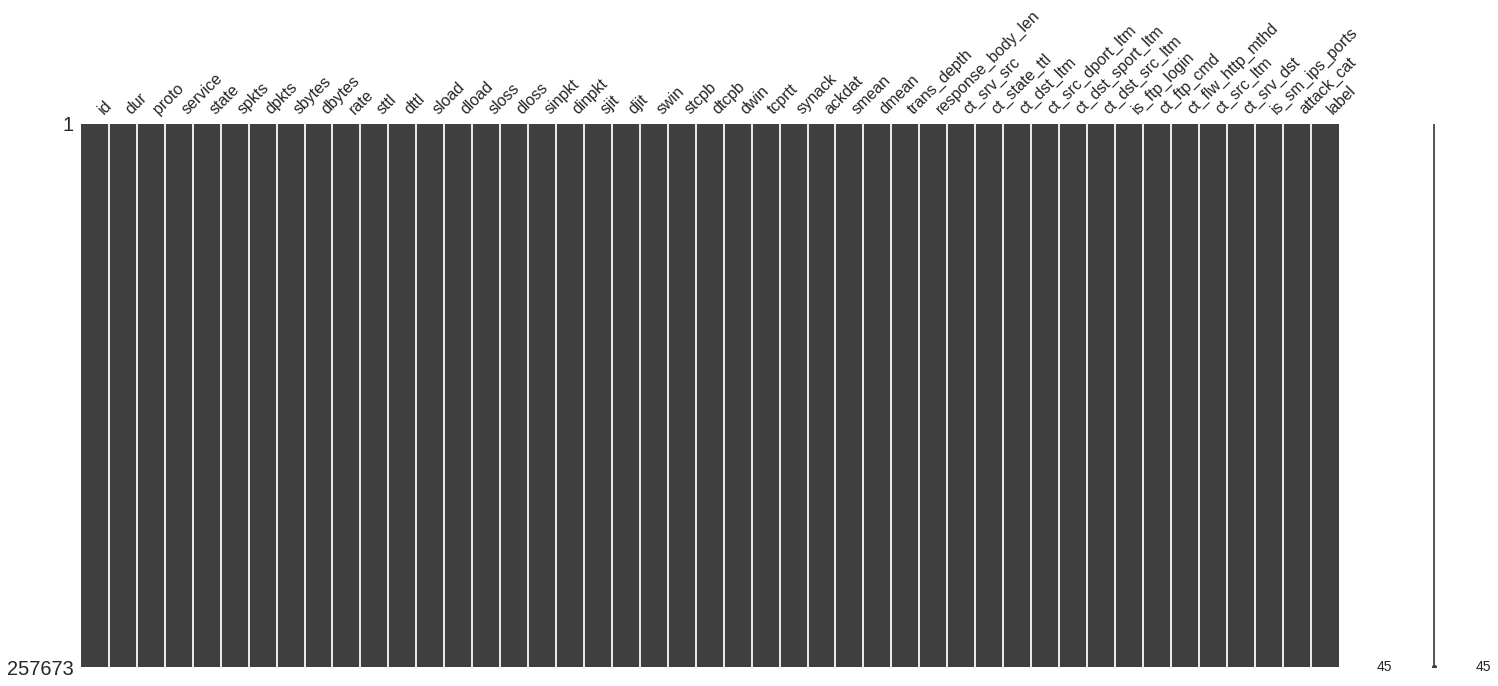

In [ ]:
#Data is clean and there are no missing values.
missingno.matrix(data)

In [ ]:
#Insights and steps:
#Data is clean.
#Data still needs furthur processing in terms of One-hot-encoding for categorical data. E.g.: 'service' consists of different types, we have ftp, http, and '-' denoting (not available or None), So we will need to treat it as a missing value as we will change it from '-' to 'None' instead of dropping the whole column.
#Removing unnecessary features like 'id'.
data['attack_cat'].unique()

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

In [ ]:
data['proto'].unique() #This is definitely a categorical feature.

array(['udp', 'arp', 'tcp', 'igmp', 'ospf', 'sctp', 'gre', 'ggp', 'ip',
       'ipnip', 'st2', 'argus', 'chaos', 'egp', 'emcon', 'nvp', 'pup',
       'xnet', 'mux', 'dcn', 'hmp', 'prm', 'trunk-1', 'trunk-2',
       'xns-idp', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'netblt', 'mfe-nsp',
       'merit-inp', '3pc', 'idpr', 'ddp', 'idpr-cmtp', 'tp++', 'ipv6',
       'sdrp', 'ipv6-frag', 'ipv6-route', 'idrp', 'mhrp', 'i-nlsp', 'rvd',
       'mobile', 'narp', 'skip', 'tlsp', 'ipv6-no', 'any', 'ipv6-opts',
       'cftp', 'sat-expak', 'ippc', 'kryptolan', 'sat-mon', 'cpnx', 'wsn',
       'pvp', 'br-sat-mon', 'sun-nd', 'wb-mon', 'vmtp', 'ttp', 'vines',
       'nsfnet-igp', 'dgp', 'eigrp', 'tcf', 'sprite-rpc', 'larp', 'mtp',
       'ax.25', 'ipip', 'aes-sp3-d', 'micp', 'encap', 'pri-enc', 'gmtp',
       'ifmp', 'pnni', 'qnx', 'scps', 'cbt', 'bbn-rcc', 'igp', 'bna',
       'swipe', 'visa', 'ipcv', 'cphb', 'iso-tp4', 'wb-expak', 'sep',
       'secure-vmtp', 'xtp', 'il', 'rsvp', 'unas', 'fc', 'iso-ip',


In [ ]:
data['service'].unique() #Here, we'll deal with the type of service that is '-'
data['service']= np.where(data['service'] == '-', 'None', data['service'])
print(data['service'].unique())

['None' 'http' 'ftp' 'ftp-data' 'smtp' 'pop3' 'dns' 'snmp' 'ssl' 'dhcp'
 'irc' 'radius' 'ssh']


In [13]:
data['state'].unique() #Keep it.

array(['INT', 'FIN', 'REQ', 'ACC', 'CON', 'RST', 'CLO', 'ECO', 'PAR',
       'URN', 'no'], dtype=object)

In [14]:
#Now, let's try to automate this process.¶
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', 'None', data[col])
    return data

In [15]:
cols = data.columns
data_bin = Remove_dump_values(data, cols)

In [16]:
data_bin = data_bin.drop(['id'], axis=1) #Remove Unnecessary features

In [17]:
data['attack_cat'].unique()

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

In [18]:
cols_cat['attack_cat'].unique()

IndexError: ignored

In [19]:
#Categorical Features:
#One Hot Encoding using cols_cat
data_bin.drop(['attack_cat'], axis=1, inplace=True)

In [20]:
cols_cat = cols_cat.drop(['attack_cat'])

In [21]:
 cols_cat.unique()

Index(['proto', 'service', 'state'], dtype='object')

In [22]:
#Do one-hot encoding
data_bin_hot = pd.get_dummies(data_bin,columns=cols_cat)

In [23]:
data_bin_hot.shape

(257673, 197)

In [27]:
#Normalization:
#Normalize all the values in the dataset.
cols_numeric = list(cols_numeric)
cols_numeric.remove('label')
cols_numeric.remove('id')

ValueError: ignored

In [28]:
data_bin_hot[cols_numeric] = data_bin_hot[cols_numeric].astype('float') 

In [29]:
data_bin_hot[cols_numeric] = (data_bin_hot[cols_numeric] - np.min(data_bin_hot[cols_numeric])) / np.std(data_bin_hot[cols_numeric])

In [30]:
data_bin_hot['attack_cat'].unique()

KeyError: ignored

In [31]:
#Train and Test set splitting:
#We won't split the Data. We care about precision in this case
from sklearn import model_selection
from sklearn import metrics
X = data_bin_hot.drop('label', axis=1)
Y = data_bin_hot['label']

In [32]:
global X #To include in upcoming functions.

In [33]:
#Machine Learning Models:
#This is a Classification problem where we want to detect whether there is an attack or not.
#We will use simple Logistic Regression.
#K-Nearest Neighbour (Lazy Algorithm)
#Decision Trees
#Random Forest (gini)
#Random Forest (Entropy or Information-gain)
def fit_algo(algo, x, y, cv):
    #Fit the model
    model = algo.fit(x, y)
    
    #Check its score
    acc = round(model.score(x, y) *100, 2)
    y_pred = model_selection.cross_val_predict(algo, x, y, cv=cv, n_jobs = -1)
    
    acc_cv = round(metrics.accuracy_score(Y,y_pred)*100, 2)
    
    return y_pred, acc, acc_cv, model

In [34]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
start_time = time.time()
pred_now, acc_lr, acc_cv_lr, lr = fit_algo(LogisticRegression(C=0.1)
                                        , X, Y, 10)

lr_time = (time.time() - start_time)

print("Accuracy: %s" % acc_lr)
print("Accuracy of CV: %s" % acc_cv_lr)
print("Execution time: %s" % lr_time)

Accuracy: 90.08
Accuracy of CV: 89.03
Execution time: 116.82967710494995


In [35]:
#Feature Importance
def feature_plot(imp):
    global X
    fimp = pd.DataFrame({'Feature': X.columns, 'Importance' : np.round(imp)})
    fimp =fimp.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10,10))
    plt.plot(fimp['Feature'], fimp['Importance'])
    plt.xticks(rotation=90);

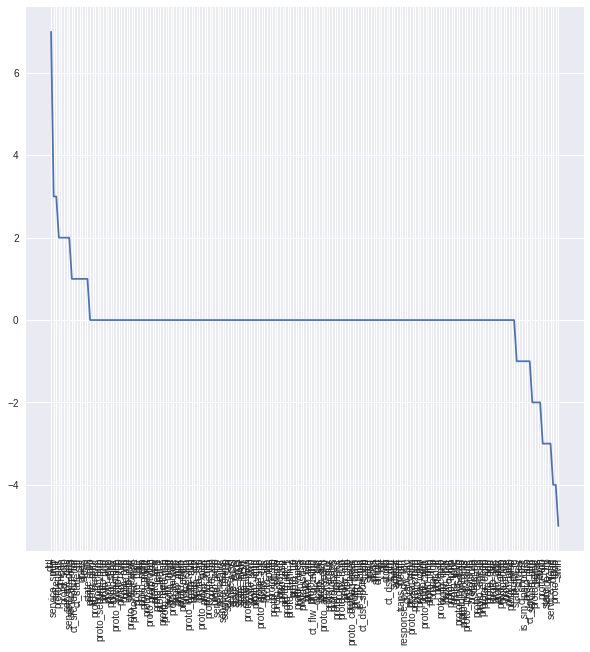

In [36]:
feature_plot(lr.coef_[0])

In [37]:
fimp_lr = pd.DataFrame({'Feature': X.columns, 'Importance' : np.round(lr.coef_[0])})
fimp_lr =fimp_lr.sort_values(by='Importance', ascending=False)
fimp_lr

,Feature,Importance
7,dttl,7.0
181,service_smtp,3.0
190,state_INT,3.0
159,proto_unas,2.0
24,dmean,2.0
...,...,...
175,service_ftp,-3.0
172,service_None,-3.0
9,dload,-4.0
158,proto_udp,-4.0


In [38]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
start_time = time.time()
pred_now, acc_dt, acc_cv_dt, dt = fit_algo(DecisionTreeClassifier(random_state = 1)
                                        , X, Y, 10)

dt_time = (time.time() - start_time)

print("Accuracy: %s" % acc_dt)
print("Accuracy of CV: %s" % acc_cv_dt)
print("Execution time: %s" % dt_time)

Accuracy: 99.74
Accuracy of CV: 91.44
Execution time: 73.72368431091309


In [39]:
#Random Forest (Gini)
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
pred_now, acc_rf, acc_cv_rf, rf = fit_algo(RandomForestClassifier(n_estimators = 100)
                                        , X, Y, 10)

rf_time = (time.time() - start_time)

print("Accuracy: %s" % acc_rf)
print("Accuracy of CV: %s" % acc_cv_rf)
print("Execution time: %s" % rf_time)

Accuracy: 99.74
Accuracy of CV: 92.62
Execution time: 416.38190245628357


In [40]:
#Random Forest (Information Gain)
from sklearn.ensemble import RandomForestClassifier
start_time = time.time()
pred_now, acc_rf2, acc_cv_rf2, rf2 = fit_algo(RandomForestClassifier(n_estimators = 100, criterion='entropy')
                                        , X, Y, 10)

rf2_time = (time.time() - start_time)

print("Accuracy: %s" % acc_rf2)
print("Accuracy of CV: %s" % acc_cv_rf2)
print("Execution time: %s" % rf2_time)

Accuracy: 99.74
Accuracy of CV: 92.63
Execution time: 458.5820486545563


In [41]:
# Neural Networks
from sklearn.neural_network import MLPClassifier

start_time = time.time()
pred_now, acc_nn, acc_cv_nn, nn = fit_algo(MLPClassifier(hidden_layer_sizes = (20,), activation='relu', solver='adam')
                                        , X, Y, 5)

nn_time = (time.time() - start_time)

print("Accuracy: %s" % acc_nn)
print("Accuracy of CV: %s" % acc_cv_nn)
print("Execution time: %s" % nn_time)

Accuracy: 93.7
Accuracy of CV: 91.14
Execution time: 1167.2927017211914


In [42]:
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
start_time = time.time()

pred_now, acc_gnb, acc_cv_gnb, gnb= fit_algo(GaussianNB()
                                        ,X,Y,5)

gnb_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gnb)
print("Accuracy of CV: %s" % acc_cv_gnb)
print("Execution time: %s" % gnb_time)

Accuracy: 50.5
Accuracy of CV: 50.46
Execution time: 16.290093183517456


In [43]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
start_time = time.time()

pred_now, acc_gbt, acc_cv_gbt, gbt= fit_algo(GradientBoostingClassifier()
                                        , X, Y, 10)

gbt_time = (time.time() - start_time)

print("Accuracy: %s" % acc_gbt)
print("Accuracy of CV: %s" % acc_cv_gbt)
print("Execution time: %s" % gbt_time)

Accuracy: 93.38
Accuracy of CV: 92.09
Execution time: 1538.2979879379272


In [44]:
#SVM
from sklearn.svm import LinearSVC
start_time = time.time()

pred_now, acc_svc, acc_cv_svc, svc= fit_algo(LinearSVC()
                                        ,X,Y,10)

svc_time = (time.time() - start_time)

print("Accuracy: %s" % acc_svc)
print("Accuracy of CV: %s" % acc_cv_svc)
print("Execution time: %s" % svc_time)

Accuracy: 90.28
Accuracy of CV: 89.21
Execution time: 510.62821912765503


In [45]:
#Cross-Validation Accuracy Comparison:
algo_name = ['Log. Reg.', 'Decision Tree', 'RandomForest Gini', 'RandomForest IG', 'Neural Network', 'Gaussian NB', 'GBC', 'SVM']
acc_df = pd.DataFrame({'Algorithm' : algo_name, 'Accuracy %' : [acc_cv_lr, acc_cv_dt, acc_cv_rf, acc_cv_rf2, acc_cv_nn, acc_cv_gnb, acc_cv_gbt, acc_cv_svc] })
acc_df = acc_df.sort_values(by='Accuracy %', ascending = False)
acc_df = acc_df.reset_index(drop=True)
acc_df

,Algorithm,Accuracy %
0,RandomForest IG,92.63
1,RandomForest Gini,92.62
2,GBC,92.09
3,Decision Tree,91.44
4,Neural Network,91.14
5,SVM,89.21
6,Log. Reg.,89.03
7,Gaussian NB,50.46


In [46]:
fimp_rf = pd.DataFrame({'Feature' : X.columns, 'Importance' : (rf.feature_importances_).astype(float)})
fimp_rf = fimp_rf.sort_values(by='Importance', ascending=False)
fimp_rf

,Feature,Importance
6,sttl,7.243439e-02
28,ct_state_ttl,6.690959e-02
5,rate,5.758462e-02
8,sload,4.539268e-02
9,dload,4.183850e-02
...,...,...
70,proto_gmtp,1.341766e-08
86,proto_ipcv,9.377596e-09
165,proto_wb-expak,5.369011e-09
79,proto_idrp,1.212291e-09


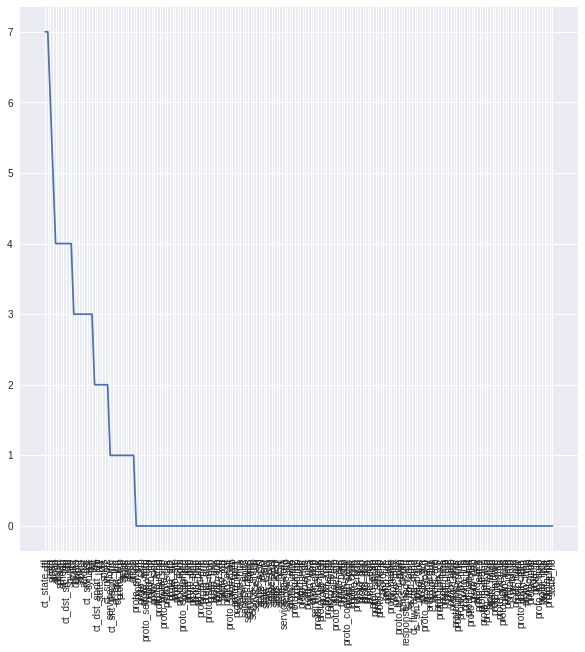

In [47]:
feature_plot(rf.feature_importances_*100)

In [48]:
#Save the best accuracy model
filename = 'RandomForest_IG_IDS.sav'
pickle.dump(rf2, open(filename, 'wb'))

In [49]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X, Y)
print(result)

0.9974347331695599
